In [76]:
# settings 
# img_size is dimension to resize images to.
img_size = (250,250)
# number of pics in each class to use. use None for all
pics_per_class = 300
#pics_per_class = None
# set zipped datafile location​img_size
data_file = '~/kaggle/competitions/plant-seedlings-classification/train.zip'

# imports
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import re
import seaborn as sns
from ds_functions import *

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [77]:
def images_to_df(filepath, img_size=(200, 200), pics_per_class=None):
    """Extracts images from data file and converts each into a pandas dataframe. 
    Outputs a pandas dataframe"""
    
    # set column names
    cols = ['px' + str(i) for i in range(1,1 + 3 * img_size[0] * img_size[1])]
    cols = ['class', 'id'] + cols   
    
    ret_df = pd.DataFrame()

    # extrac the images through each folder. 
    if not os.path.isdir('./train'):
        zfile = zipfile.ZipFile(filepath)
        zfile.extractall()

    for dname in os.listdir('./train'):
        if os.path.isdir('./train/' + dname):
            for fname in os.listdir('./train/' + dname)[0:pics_per_class]:
                cl = dname
                ix = fname[:-4]
                im = cv2.imread('./train/' + dname + '/' + fname)
                
                # to put into an DataFrame for classification, 
                # all the images need to be the same dimension. 
                im = cv2.resize(im, (img_size[0],img_size[1])).reshape(-1)
                im = im.reshape(1, len(im))
                df = pd.DataFrame({
                    'class':[cl],
                    'id':[ix]
                })
                df = df.join(pd.DataFrame(im))
                ret_df = pd.concat([ret_df, df])
    ret_df.columns = cols
    return ret_df.reset_index(drop=True)

In [120]:
# Create a class that will take in the data and return a trained model with 
# results
class sk_cls():
    """sk_cls takes an sk-learn classifier, pandas dataset, and list of features and
    target variables, and builds a trained model with results statistics"""
    
    def __init__(self, cls, data, X, y, ratio=0.1):
        # check data
        if data.isnull().sum().any():
            raise Exception('Data contains NA values. Correct before attempting to model')
        
        # set initial variables
        self.model = cls
        self.score = 0
        self.conf_matrix = None
        self.cls_report = None
        self.__tgt = y
        self.__ftr = X
        
        # create train test split
        self.__X_train, self.__X_test, self.__y_train, self.__y_test = train_test_split(
            data.loc[:, self.__ftr],
            data.loc[:, self.__tgt], test_size=ratio)
    
    def train_cls(self, cls, X_train, X_test, y_train, y_test):
        """Fir the model and """
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        sc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        
        results = {
            'cls':cls,
            'sc':sc,
            'cm':cm,
            'cr':cr
        }
        return results
    
    def run(self):
        """Run the model"""
        results = self.train_cls(self.model, 
                                 self.__X_train, self.__X_test, 
                                 self.__y_train, self.__y_test)
        self.model = results['cls']
        self.score = results['sc']
        self.conf_matrix = results['cm']
        self.cls_report = results['cr']
        
    def show(self, cm_plot=True, title=None, cbar=False, normed=True):
        """outputs all results including a cm plot"""
        if self.score == 0:
            raise Exception('Model has not been run. Use sk_cls.run() first')
            
        print('Score:\n', self.score)
        print('Classification Report:\n', self.cls_report)
        if cm_plot:
            title = 'Confusion Matrix' if title == None else title
            sorted_classes = sorted(data.loc[:, self.__tgt].unique())
            print(type(cm_plot), type(self.conf_matrix), type(sorted_classes), type(title), title)
            #cm_plot(self.conf_matrix, classes=sorted_classes, title=title)
            plt.show()


In [80]:
# load the data
data = images_to_df(data_file, 
                    img_size=img_size,
                    pics_per_class=pics_per_class)

In [102]:
# try plotting the data. See what color is the most common
colrange = {}
for i in range(1,4):
    colrange[i] = ['px' + str(j) for j in range(1 + (i-1), img_size[0] * img_size[1], 3)]
    
color_sums = pd.DataFrame({
    'id': data.loc[:, 'id']
})

for i in range(1,4):
    color_sums['color_sum' + str(i)] = data.loc[:, colrange[i]].sum(axis=1).reset_index(drop=True)
    # also add the average
    color_sums['color_mean' + str(i)] = data.loc[:, colrange[i]].mean(axis=1).reset_index(drop=True)
    
# I'll try joining the total color data to the pixel data and include the sum of each color as a feature
if not 'color_sum1' in list(data.columns):
    data = data.merge(color_sums, on='id')

data.head()


In [107]:
# Set features and target
features = ['px' + str(i) for i in range(1,1 + 3 * img_size[0] * img_size[1])] 
features += ['color_sum'+str(i) for i in range(1,4)]
features += ['color_mean'+str(i) for i in range(1,4)]

target = 'class'


False

In [57]:
mlp = MLPClassifier() # start with default settings

mlp_model = sk_cls(mlp, data, X=features, y=target)

C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        34
                 Charlock       0.00      0.00      0.00        26
                 Cleavers       0.00      0.00      0.00        27
         Common Chickweed       0.00      0.00      0.00        29
             Common wheat       0.00      0.00      0.00        19
                  Fat Hen       0.00      0.00      0.00        31
         Loose Silky-bent       0.10      1.00      0.18        32
                    Maize       0.00      0.00      0.00        22
        Scentless Mayweed       0.00      0.00      0.00        24
          Shepherds Purse       0.00      0.00      0.00        24
Small-flowered Cranesbill       0.00      0.00      0.00        34
               Sugar beet       0.00      0.00      0.00        31

              avg / total       0.01      0.10      0.02       333

                         actual         predicted
2313     

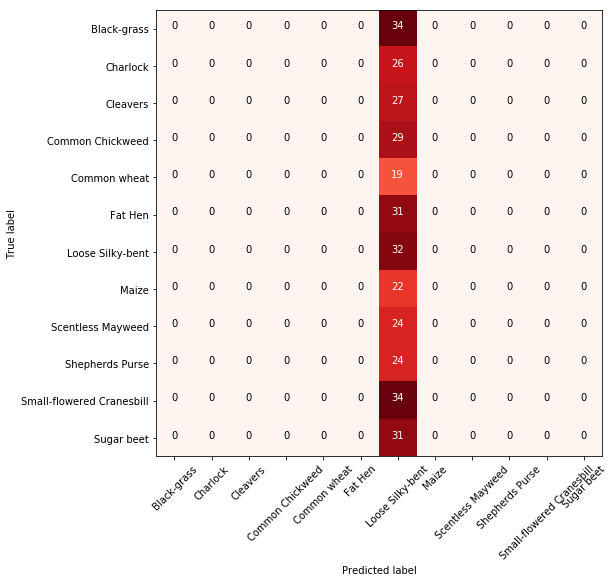

In [25]:
mlp_model.run()
mlp_model.show()

# MLP appears to be totally useless for this data. At least in its current form

In [109]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4)

rf_model = sk_cls(rf, data, X=features, y=target)

In [110]:
rf_model.run()

      px1  px2  px3  px4  px5  px6  px7  px8  px9  px10     ...       \
1551   35   50   69   39   55   73   42   56   72    38     ...        
2725   62   69   81   70   75   87   62   69   85    58     ...        
1234   64   85   97   64   85   97   63   84   96    62     ...        
2413   60   82  100   58   80   98   55   75   94    53     ...        
832    95  111  120   98  113  120  101  114  121   102     ...        
1315   51   61   72   51   61   72   53   63   73    54     ...        
1926   75   94  114   70   89  111   66   85  108    64     ...        
79     55   54   64   57   57   67   55   55   64    56     ...        
1198   59   82   99   54   74   91   53   68   83    60     ...        
1280   59   75   96   59   74   96   59   73   95    59     ...        
2675   43   57   67   32   55   68   48   74   87    63     ...        
1950   35   45   66   33   48   69   35   54   74    49     ...        
2414   31   56   82   33   59   84   38   65   88    39     ... 

0.5435435435435435
                           precision    recall  f1-score   support

              Black-grass       0.70      0.48      0.57        29
                 Charlock       0.62      0.62      0.62        34
                 Cleavers       0.53      0.73      0.61        26
         Common Chickweed       0.80      0.62      0.70        32
             Common wheat       0.54      0.33      0.41        21
                  Fat Hen       0.44      0.63      0.52        30
         Loose Silky-bent       0.33      0.43      0.37        35
                    Maize       0.67      0.53      0.59        15
        Scentless Mayweed       0.54      0.75      0.63        28
          Shepherds Purse       0.75      0.12      0.21        25
Small-flowered Cranesbill       0.56      0.83      0.67        23
               Sugar beet       0.56      0.43      0.48        35

              avg / total       0.58      0.54      0.53       333



Text(0.5,-36.3156,'Predicted label')

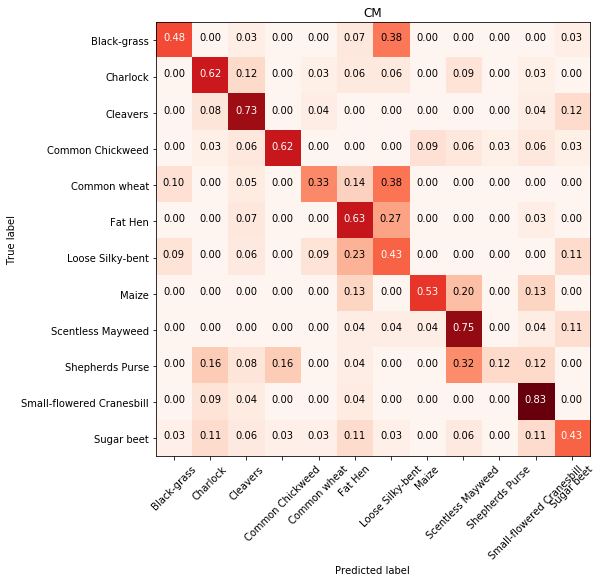

In [118]:
print(rf_model.score)
print(rf_model.cls_report)
cm_plot(rf_model.conf_matrix, 
        classes=sorted(data.loc[:, target].unique()), 
        title='CM', normalize=True, cbar=False)

# only about 54% accurate. Getting a 12 category classification right half the time isn't bad.
# more samples might help?


In [ ]:
# since the green part of the image is really the only important part, seeing how we're classifying 
# plants, what happens if I only use the green pixels?

# next step: look up documentation on OpenCV and see how I can extract only the green or green-ish
# or yellowish pixels. Display the images with only the greens. 

# or perhaps use a batch processing to recode all the images to highlight only the plant part.
# would enhacing the plant parts make a difference, or can sklearn already tell teh difference?

# the bottom image creates the most distction as possible between the plant parts and the gravel parts
# at least to my eyes.

# use Gimp's Max RGB function, then adjust the Red Saturation down to zero, and that will give an image
# that only shows the green parts.

In [ ]:
gb = GradientBoostingClassifier(n_jobs=4)

gb_model = sk_cls(gb, data, X=features, y=target)
gb_model.run()

In [ ]:
gb_model.show()

Some attempts to modify the image to create more contrast. Tried adjusting the Hue-Saturation balance, and also the color
balance to make the gravel stand out more from the plant

<img src="./images/original_image.png" height="300" width="300"> 
<img src="./images/reshaded image.png" height="300" width="300">
<img src="./images/colorized_image.png" height="300" width="300">
<img src="./images/max_rgb.png" height="300" width="300">


To create these max contrast images, I first applied Gimp's Maximum RGB which will separate the plant from the gravel. Adjust the Hue-Saturation, set the Hue and Brightness for Red to max, and Saturation to min. This will turn the gravel mostly white. Set the Brightness for green up a bit. This will make the shape of the green stand out significantly.

With this, the shapes of the plant part of the images is very clear, at least to human eyes. By reducing "noise" in the image (i.e. the non-plant parts that don't matter), I now want to see if the classifier can better distinguish the different plants

#### To do next: Create script to process images to highlight only the plant part
<img src="./images/max_contrast.png" height="300" width="300">
<img src="./images/max_contrast_2.png" height="300" width="300">
<img src="./images/max_contrast_3.png" height="300" width="300">